># **_Raffi Dilanchian_ -            951811193016**
># **_MohammadHossein Komeili_ -     951811193033**
>### **K_means** and **FCM** clustering algorithm on **AT&T** dataset assignment

# Preparing data

In [1]:
# importing main libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from os.path import join
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
# ReadFile method for reading and resizing images

data_folder = "att_faces/s"

def ReadFile(num,index):
    file_path = join(data_folder + str(num), str(index) + ".pgm")
    loaded_image=np.array(plt.imread(file_path))
    image_32x32 = cv2.resize(loaded_image, (32, 32), interpolation=cv2.IMREAD_GRAYSCALE)
    image_1024 = image_32x32.reshape(-1)
    return image_1024
    

In [3]:
X = np.array([],dtype=int)
y = []

for folder in range(1,41):
    for index in range(1,11):
        image_1024 = ReadFile(folder, index)
        X = np.concatenate((X,image_1024),axis=0)
        y.append(folder)
        
X = np.reshape(X, (400, 1024))

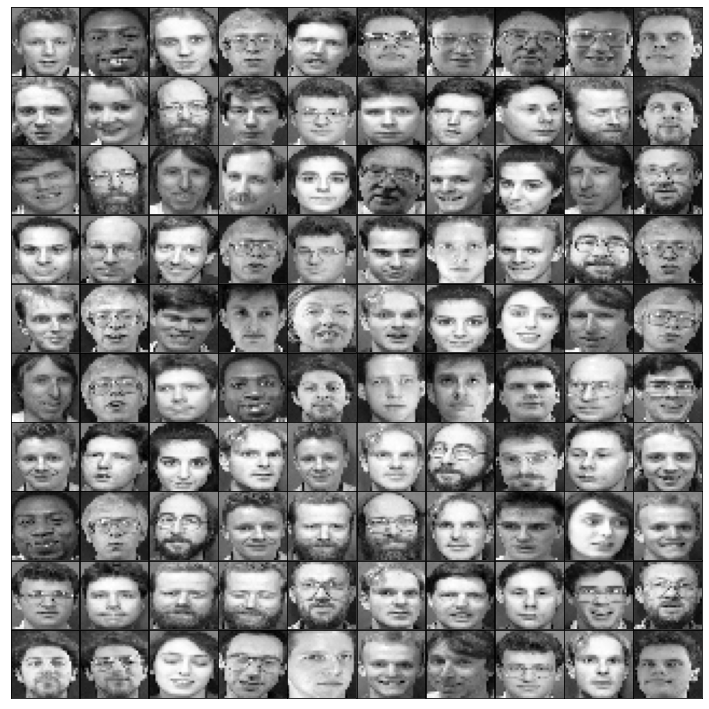

In [4]:
X_samples = np.random.permutation(X)[:100]

fig, axes = plt.subplots(10, 10, figsize=(16, 16))
fig.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8, hspace=0.01, wspace=0.01)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_samples[i].reshape((32,32)), cmap='gray')
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [5]:
print("shape of X: ", np.shape(X))
print("shape of y: ", np.shape(y))

shape of X:  (400, 1024)
shape of y:  (400,)


## Reduction (PCA)

In [6]:
stScaler = StandardScaler()
X = stScaler.fit_transform(X)

In [7]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X)
U = pca.components_          # Principal Components (directions)
S = pca.explained_variance_  # importance of ecah direction (variances)
print("1st Principal Component: {} ({:.2f})".format(U[0], S[0]))
print("2nd Principal Component: {} ({:.2f})".format(U[1], S[1]))

1st Principal Component: [-0.03201987 -0.0320306  -0.03310122 ...  0.02048914  0.01858923
  0.0220235 ] (168.05)
2nd Principal Component: [-0.04696301 -0.04715656 -0.04645918 ... -0.00859963 -0.01102693
 -0.00071192] (129.06)


In [8]:
print(np.linalg.norm(U[0]))
print(np.linalg.norm(U[1]))
print(np.dot(U[0], U[1]))

1.0000000000000007
1.0000000000000002
-3.5778671692021646e-17


In [9]:
# X_proj = pca.fit_transform(X)  # project from 64 to 2 dimensions
X_proj = pca.transform(X)

print("Shape of original data:  {}".format(X.shape))
print("Shape of projected data: {}".format(X_proj.shape))




Shape of original data:  (400, 1024)
Shape of projected data: (400, 2)


## Visualization of reduced data with actual labels

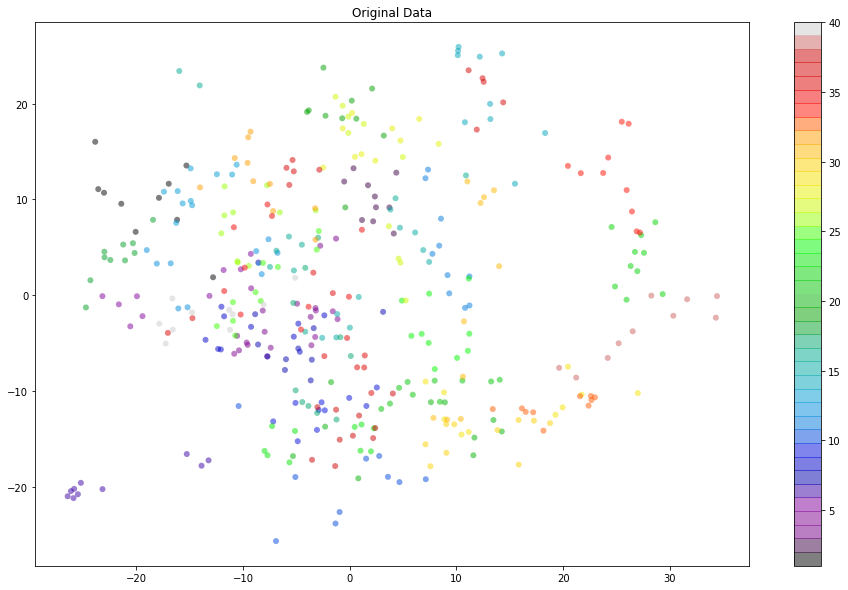

In [10]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], 
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 40))
plt.colorbar()
plt.title('Original Data')
plt.show()

# Clustering
>### K-means
>### FCM

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
from fcmeans import FCM

In [12]:
def getMapping(predictedLabels,actualLabels):
    labels_mapping = np.array([],dtype=int)
    for i in range(40): # for each cluster number
        i_indices = np.where(predictedLabels==i)[0] # get indices of elements from i-th cluster
        i_actual_labels = actualLabels[i_indices.astype(int)] # get actual labels of i-th predicted cluster elements
        most_reapeated_label = np.argmax(np.bincount(i_actual_labels)) # get majority vote of actual labels of i-th cluster
        labels_mapping = np.append(labels_mapping,most_reapeated_label) # append tu mapping array
    return labels_mapping

In [13]:
number_of_itterations = 20
mean_accuracy_kmeans = 0
mean_accuracy_fcm = 0
mean_silhouette_kmeans = 0
mean_silhouette_fcm = 0

for itter in range(number_of_itterations):
    kmeans = KMeans(n_clusters=40)
    kmeans_labels = kmeans.fit_predict(X_proj)
    
    labels=np.array(y)
    kmeans_labels_mapping = np.array([],dtype=int)
    
    kmeans_labels_mapping = getMapping(kmeans_labels,labels)
        

    fcm = FCM(n_clusters=40)
    fcm.fit(X_proj)
    fcm_centers = fcm.centers
    fcm_labels  = fcm.u.argmax(axis=1)
    
    fcm_labels_mapping = getMapping(fcm_labels,labels)

    
    mean_accuracy_kmeans += accuracy_score(y,list(map(lambda x: kmeans_labels_mapping[x],kmeans_labels))) #usnig label mapping
    mean_silhouette_kmeans += silhouette_score(X_proj, kmeans_labels)
    
    mean_accuracy_fcm += accuracy_score(y,list(map(lambda x: fcm_labels_mapping[x],fcm_labels))) #usnig label mapping
    mean_silhouette_fcm += silhouette_score(X_proj, fcm_labels)
    
mean_accuracy_kmeans /= number_of_itterations
mean_silhouette_kmeans /= number_of_itterations
mean_accuracy_fcm /= number_of_itterations
mean_silhouette_fcm /= number_of_itterations

In [14]:
print("mean accuracy for K-means: %.2f" % (mean_accuracy_kmeans*100))
print("mean silhouette for K-means: %.2f\n" % (mean_silhouette_kmeans*100))

print("mean accuracy for FCM: %.2f " % (mean_accuracy_fcm*100))
print("mean silhouette for FCM: %.2f" % (mean_silhouette_fcm*100))

mean accuracy for K-means: 47.11
mean silhouette for K-means: 40.86

mean accuracy for FCM: 46.75 
mean silhouette for FCM: 34.65


## Visualization of clustered data by K-Means 

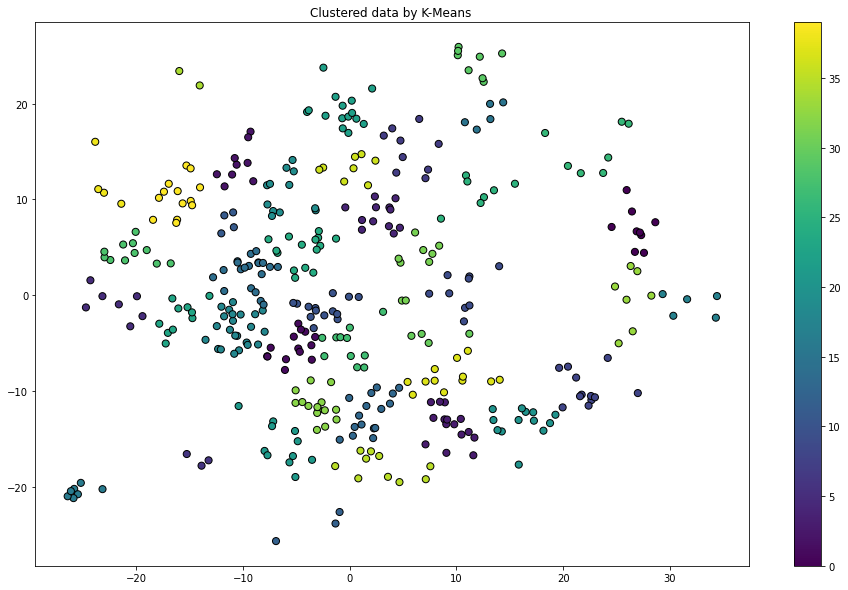

In [15]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], edgecolors='k', s=50, c=kmeans_labels);
plt.colorbar()
plt.title('Clustered data by K-Means ')
plt.show()

## Visualization of clustered data by FCM

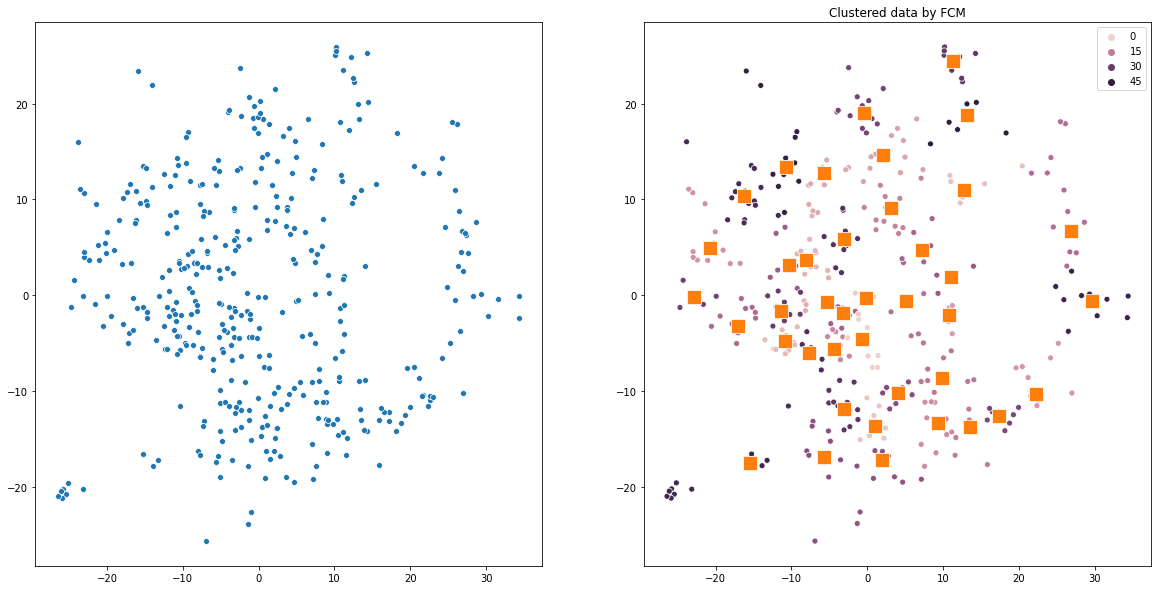

In [17]:
from seaborn import scatterplot as scatter
# plot result

f, axes = plt.subplots(1, 2, figsize=(20,10))
plt.title('Clustered data by FCM')
scatter(X_proj[:,0], X_proj[:,1], ax=axes[0])
scatter(X_proj[:,0], X_proj[:,1], ax=axes[1], hue=fcm_labels)
scatter(fcm_centers[:,0], fcm_centers[:,1], ax=axes[1],marker="s",s=200)
plt.show()